# Dataset analysis 

In [1]:
import numpy as np
import math
import pandas as pd
import os.path
import matplotlib.pyplot as plt
from typing import List, Dict
from PIL import Image
import seaborn as sns
import json
from matplotlib import cm
from pprint import pformat
import json
import cv2
import tikzplotlib

from sklearn.metrics import confusion_matrix


plt.style.use("seaborn")
sns.color_palette("colorblind")

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [2]:
colormap = cm.get_cmap('gist_stern_r')

print([f'class {i} : colormap {colormap(i*51)}' for i in range(6)])

['class 0 : colormap (1.0, 1.0, 1.0, 1.0)', 'class 1 : colormap (0.8, 0.8, 0.24528301886792458, 1.0)', 'class 2 : colormap (0.6, 0.6, 0.5744680851063829, 1.0)', 'class 3 : colormap (0.3999999999999999, 0.4, 0.8, 1.0)', 'class 4 : colormap (0.27610394265232974, 0.19999999999999996, 0.4, 1.0)', 'class 5 : colormap (0.0, 0.0, 0.0, 1.0)']


In [3]:

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np

def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])
    
    print(f'x-span : {[x_middle - plot_radius, x_middle + plot_radius]}')
    print(f'y-span : {[y_middle - plot_radius, y_middle + plot_radius]}')
    print(f'z-span : {[z_middle - plot_radius, z_middle + plot_radius]}')

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

In [4]:
def illustrate_mask(dataset:str, source:str, image_nr:int, slice_nr:int, F_points = False, base_path = r'/media/jan/DataStorage/ProjectData/temp/') :
    image_path = os.path.join(base_path, dataset, f'{source}_images', f'image{image_nr:03d}', f'slice_{slice_nr:03d}.jpg')
    mask_path = os.path.join(base_path, dataset,  f'{source}_masks', f'image{image_nr:03d}', f'slice_{slice_nr:03d}.npy')

    im = Image.open(image_path)
    mask = np.load(mask_path)

    if F_points:
        points_path = os.path.join(base_path, dataset,  f'{source}_masks', f'image{image_nr:03d}', f'slice_{slice_nr:03d}_points.npy')
        points = np.load(points_path)

    mask_im = Image.fromarray(np.uint8(cm.gist_stern_r(mask*51)*255)).convert('RGB')
    mask_im = cv2.addWeighted(np.array(im), 0.3,np.array(mask_im), 0.7, 0)

    if F_points: 
        fig = plt.figure(figsize=(10,10))
        cols = 3
    else :
        fig = plt.figure(figsize=(10,10))
        cols = 2
    plt.subplot(1,cols,1)
    plt.yticks([])
    plt.xticks(np.linspace(0, im.size[0]-1, 2))
    plt.title('image slice')
    plt.imshow(np.asarray(im))
    plt.grid(False)
    plt.subplot(1,cols,2)
    plt.yticks([])
    plt.xticks([])
    plt.imshow(mask_im)
    plt.title('Ground truth mask')
    plt.grid(False)
    if F_points:
        im = cv2.addWeighted(np.array(im), 0.3,np.ones_like(np.array(im)) * 255, 0.7, 0)
        cmap = cm.get_cmap('gist_stern_r')

        for label_num in range(6):
            y_c, x_c = np.where(points == label_num)
            colour = tuple([c * 255 for c in cmap(label_num*51)])

            for y_i, x_i in zip(y_c, x_c):
                im = cv2.circle(im, (x_i, y_i), 2, colour, -1)
        plt.subplot(1,cols,3)
        plt.yticks([])
        plt.xticks([])
        plt.imshow(im)
        plt.grid(False)
        plt.title('Point annotation')
    return fig

In [5]:
def illustrate_mask_plus(dataset:str, source:str, image_nr:int, slice_nr:int, F_points = False, base_path = r'/media/jan/DataStorage/ProjectData/temp/') :
    image_path = os.path.join(base_path, dataset, f'{source}_images', f'image{image_nr:03d}', f'slice_{slice_nr:03d}.jpg')
    image2_path= os.path.join(base_path, dataset.replace('2', '0'), f'{source}_images', f'image{image_nr:03d}', f'slice_{slice_nr:03d}.jpg')
    mask_path = os.path.join(base_path, dataset,  f'{source}_masks', f'image{image_nr:03d}', f'slice_{slice_nr:03d}.npy')

    im = Image.open(image_path)
    im2=  Image.open(image2_path)
    mask = np.load(mask_path)

    if F_points:
        points_path = os.path.join(base_path, dataset,  f'{source}_masks', f'image{image_nr:03d}', f'slice_{slice_nr:03d}_points.npy')
        points = np.load(points_path)

    mask_im = Image.fromarray(np.uint8(cm.gist_stern_r(mask*51)*255)).convert('RGB')
    mask_im = cv2.addWeighted(np.array(im), 0.3,np.array(mask_im), 0.7, 0)
    
    
    fig = plt.figure(figsize=(20,7))
    cols = 3
    temp = plt.subplot(1,cols,1)
    plt.yticks([])
    plt.xticks(np.linspace(0, im2.size[0]-1, 2))
    plt.title('image slice')
    plt.imshow(np.asarray(im2))
    plt.grid(False)
    temp.set_anchor('S')
    temp2 = plt.subplot(1,cols,2)
    plt.yticks([])
    plt.xticks(np.linspace(0, im.size[0]-1, 2))
    plt.title('image slice')
    plt.imshow(np.asarray(im))
    plt.grid(False)
    temp2.set_anchor('S')
    temp3 = plt.subplot(1,cols,3)
    plt.yticks([])
    plt.xticks([])
    plt.imshow(mask_im)
    plt.title('Ground truth mask')
    plt.grid(False)
    temp3.set_anchor('S')
    return fig

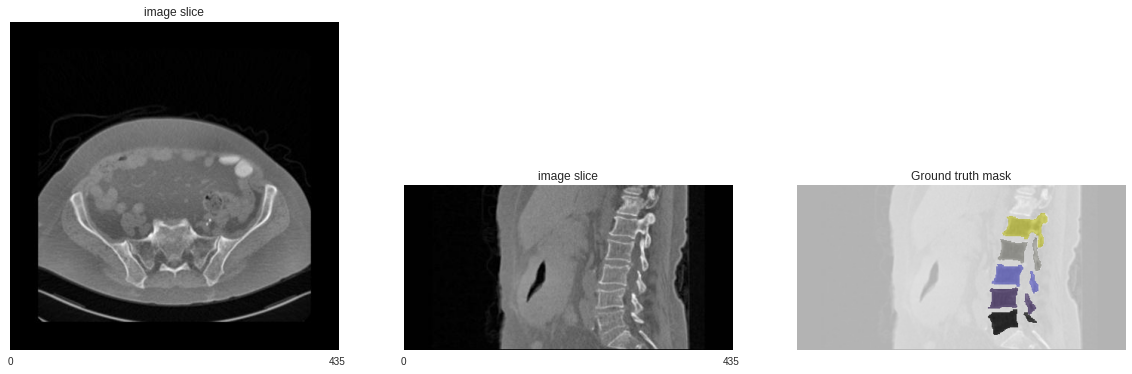

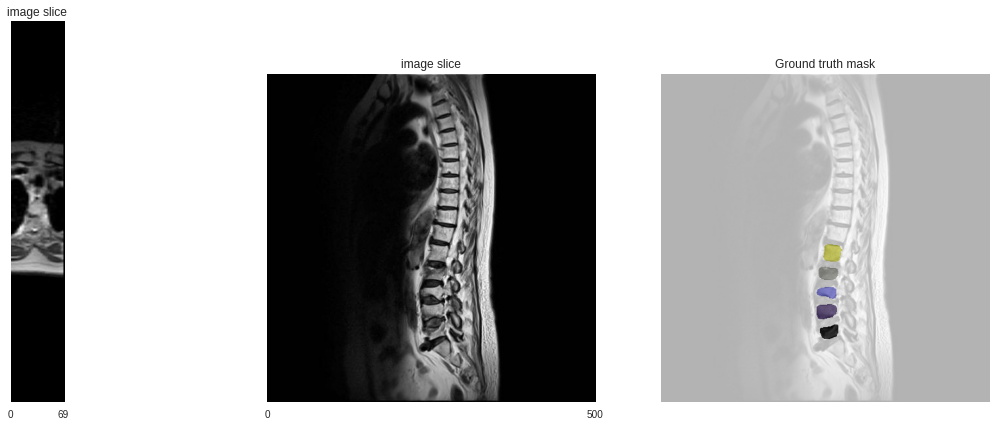

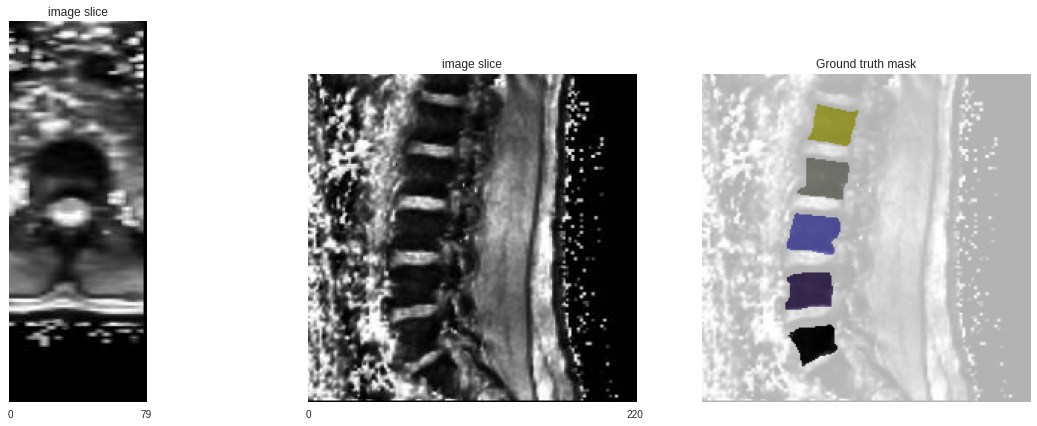

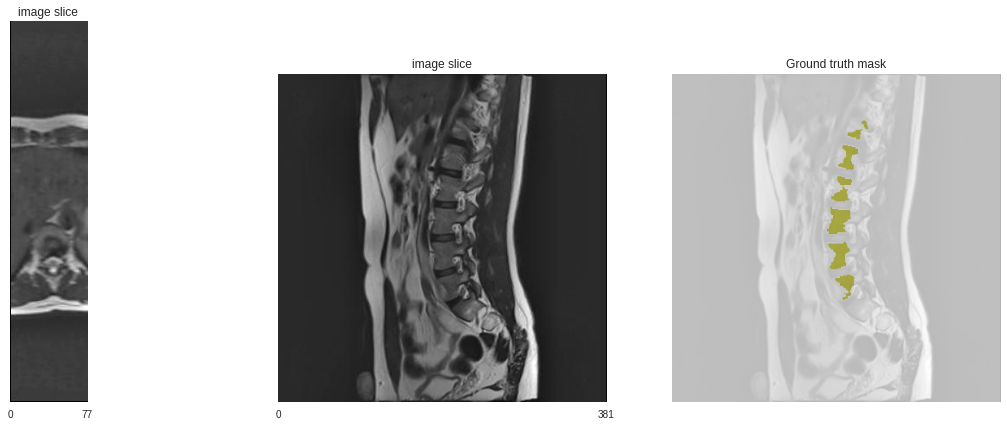

In [6]:
f = illustrate_mask_plus(r'dataset_2_contrast_3', r'xVertSeg', 4, 210)
plt.savefig('xVertSeg004_s210_mask.png', bbox_inches = 'tight')

f = illustrate_mask_plus(r'dataset_2_contrast_3', r'USiegen', 4, 20)
plt.savefig('USiegen004_s20_mask.png', bbox_inches = 'tight')

f = illustrate_mask_plus(r'dataset_2_contrast_3', r'MyoSegmenTUM', 20, 21)
plt.savefig('MyoSegmenTUM020_s21_mask.png', bbox_inches = 'tight')

f = illustrate_mask_plus(r'dataset_2_contrast_3', r'PLoS', 8, 21)
plt.savefig('PLoS_s8_mask.png', bbox_inches = 'tight')

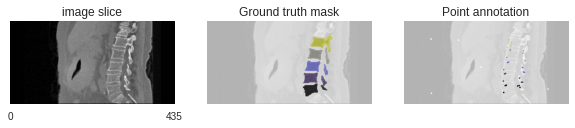

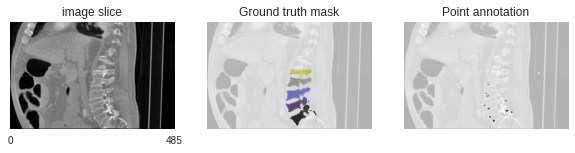

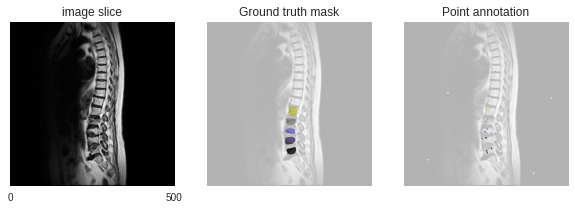

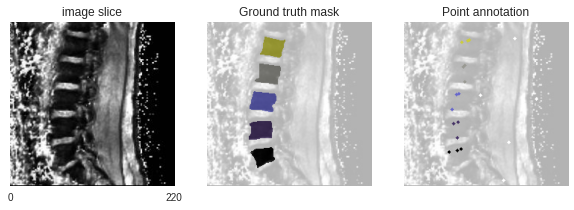

In [7]:
f = illustrate_mask(r'dataset_2_contrast_3', r'xVertSeg', 4, 210, F_points = True)
plt.savefig('xVertSeg004_s210_points.pdf', bbox_inches = 'tight')

f = illustrate_mask(r'dataset_2_contrast_3', r'xVertSeg', 7, 210, F_points = True)
plt.savefig('xVertSeg007_s210_points.pdf', bbox_inches = 'tight')

f = illustrate_mask(r'dataset_2_contrast_3', r'USiegen', 4, 20, F_points=True)
plt.savefig('USiegen004_s20_points.pdf', bbox_inches = 'tight')

f = illustrate_mask(r'dataset_2_contrast_3', r'MyoSegmenTUM', 20, 21, F_points=True)
plt.savefig('MyoSegmenTUM020_s21_points.pdf', bbox_inches = 'tight')

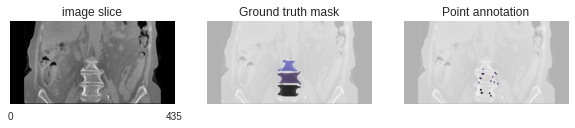

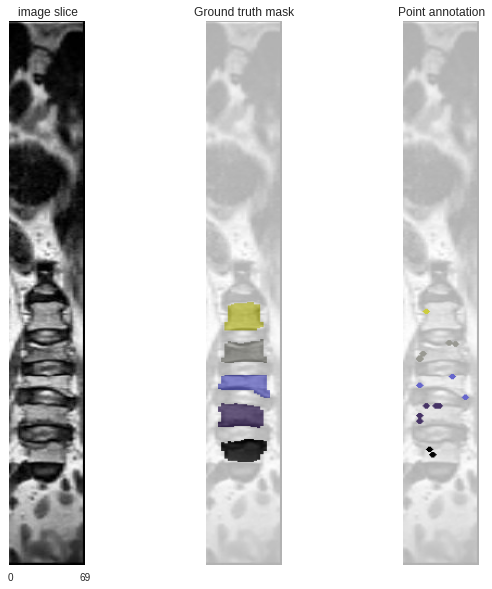

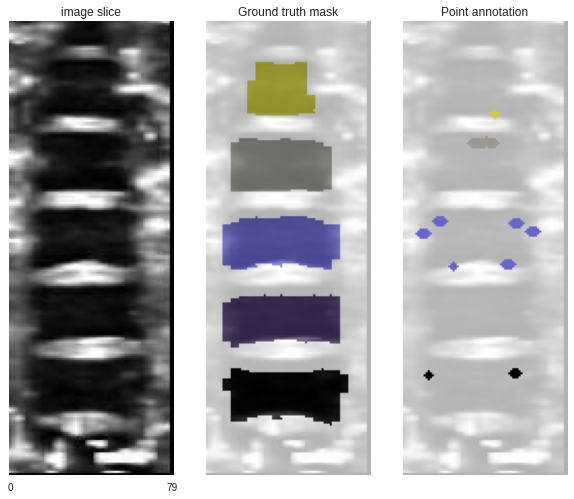

In [8]:
f = illustrate_mask(r'dataset_1_contrast_3', r'xVertSeg', 4, 265, F_points = True)
plt.savefig('xVertSeg004_s265_front_points.pdf', bbox_inches = 'tight')

f = illustrate_mask(r'dataset_1_contrast_3', r'USiegen', 4, 250, F_points=True)
plt.savefig('USiegen004_s250_front_points.pdf', bbox_inches = 'tight')

f = illustrate_mask(r'dataset_1_contrast_3', r'MyoSegmenTUM', 20, 75, F_points=True)
plt.savefig('MyoSegmenTUM020_s75_front_points.pdf', bbox_inches = 'tight')

In [9]:
def confusion_matrix_testset(result_folder):
    base_path = r'/media/jan/DataStorage/ProjectData/temp/'
    dataset = r'dataset_2_contrast_3'

    results_folder = os.path.join(base_path, result_folder, 'dimension_2_split_test')
    conf_matr = np.zeros((6,6))
    for scan in os.listdir(results_folder):
        if not scan.endswith('.npy'):
            continue
        print(scan)
        _, source, image_nr, _ = scan.split('_')
        mask_path = os.path.join(base_path, dataset,  f'{source}_masks', f'image{image_nr}', 'mask_array.npy')
        result_path = os.path.join(base_path, result_folder,  'dimension_2_split_test', f'scan_{source}_{image_nr}_res.npy')

        result = np.load(result_path).astype('uint8')
        mask = np.load(mask_path).astype('uint8')

        conf_matr += confusion_matrix(mask.reshape(-1), result.reshape(-1), labels=[i for i in range(6)])
        
    conf_matr /= conf_matr.sum(axis=0)
    conf_matr *= 100
    return np.around(conf_matr, decimals = 2)

# np.set_printoptions(precision=2)

full_conf = confusion_matrix_testset(r'reconstruct_full')
pseudo_conf = confusion_matrix_testset(r'reconstruct_pseudo')

pd.DataFrame(full_conf).to_csv("full_conf_matrix.csv")
pd.DataFrame(pseudo_conf).to_csv("pseudo_conf_matrix.csv")

print(full_conf)
print(pseudo_conf)

scan_USiegen_011_res.npy
scan_MyoSegmenTUM_024_res.npy
scan_MyoSegmenTUM_049_res.npy
scan_MyoSegmenTUM_051_res.npy
scan_xVertSeg_011_res.npy
scan_xVertSeg_014_res.npy
scan_MyoSegmenTUM_022_res.npy
scan_MyoSegmenTUM_012_res.npy
scan_MyoSegmenTUM_006_res.npy
scan_USiegen_012_res.npy
scan_MyoSegmenTUM_011_res.npy
scan_MyoSegmenTUM_002_res.npy
scan_MyoSegmenTUM_035_res.npy
scan_USiegen_011_res.npy
scan_MyoSegmenTUM_024_res.npy
scan_MyoSegmenTUM_049_res.npy
scan_MyoSegmenTUM_051_res.npy
scan_xVertSeg_011_res.npy
scan_xVertSeg_014_res.npy
scan_MyoSegmenTUM_022_res.npy
scan_MyoSegmenTUM_012_res.npy
scan_MyoSegmenTUM_006_res.npy
scan_USiegen_012_res.npy
scan_MyoSegmenTUM_011_res.npy
scan_MyoSegmenTUM_002_res.npy
scan_MyoSegmenTUM_035_res.npy
[[9.986e+01 1.316e+01 1.450e+01 1.418e+01 1.293e+01 1.209e+01]
 [3.000e-02 8.661e+01 2.060e+00 1.000e-01 1.900e-01 0.000e+00]
 [3.000e-02 2.000e-01 8.336e+01 9.000e-01 7.000e-02 1.000e-02]
 [2.000e-02 2.000e-02 9.000e-02 8.386e+01 3.500e-01 1.000e-02]
 [3.

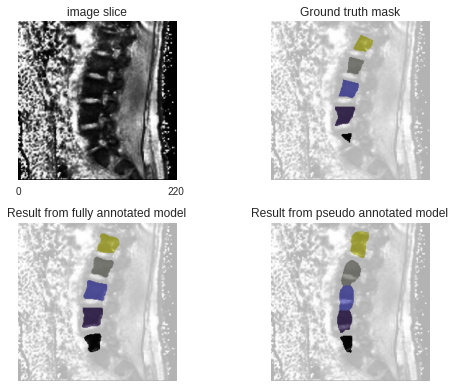

In [10]:
base_path = r'/media/jan/DataStorage/ProjectData/temp/'
result_folder_full = r'reconstruct_full'
result_folder_pseudo = r'reconstruct_pseudo'
dataset = r'dataset_2_contrast_3'
source = r'MyoSegmenTUM'
image_nr = 24
slice_nr = 23


mask_path = os.path.join(base_path, dataset,  f'{source}_masks', f'image{image_nr:03d}', 'mask_array.npy')
result_path_full = os.path.join(base_path, result_folder_full,  'dimension_2_split_test', f'scan_{source}_{image_nr:03d}_res.npy')
result_path_pseudo = os.path.join(base_path, result_folder_pseudo,  'dimension_2_split_test', f'scan_{source}_{image_nr:03d}_res.npy')
image_path = os.path.join(base_path, dataset, f'{source}_images', f'image{image_nr:03d}', f'slice_{slice_nr:03d}.jpg')


im = Image.open(image_path)
mask = np.take(np.load(mask_path), slice_nr, axis=2)
result_full = np.take(np.load(result_path_full), slice_nr, axis=2)
result_pseudo = np.take(np.load(result_path_pseudo), slice_nr, axis=2)

mask_im = Image.fromarray(np.uint8(cm.gist_stern_r(mask*51)*255)).convert('RGB')
mask_im = cv2.addWeighted(np.array(im), 0.3,np.array(mask_im), 0.7, 0)

result_full_im = Image.fromarray(np.uint8(cm.gist_stern_r(result_full*51)*255)).convert('RGB')
result_full_im = cv2.addWeighted(np.array(im), 0.3,np.array(result_full_im), 0.7, 0)

result_pseudo_im = Image.fromarray(np.uint8(cm.gist_stern_r(result_pseudo*51)*255)).convert('RGB')
result_pseudo_im = cv2.addWeighted(np.array(im), 0.3,np.array(result_pseudo_im), 0.7, 0)


plt.subplot(2,2,1)
plt.title('image slice')
plt.yticks([])
plt.xticks(np.linspace(0, im.size[0]-1, 2))
plt.imshow(np.asarray(im))
plt.grid(False)
plt.subplot(2,2,2)
plt.yticks([])
plt.xticks([])
plt.imshow(mask_im)
plt.grid(False)
plt.title('Ground truth mask')
plt.subplot(2,2,3)
plt.yticks([])
plt.xticks([])
plt.imshow(result_full_im)
plt.grid(False)
plt.title('Result from fully annotated model')
plt.subplot(2,2,4)
plt.yticks([])
plt.xticks([])
plt.imshow(result_pseudo_im)
plt.grid(False)
plt.title('Result from pseudo annotated model')
plt.tight_layout()

plt.savefig(f'fullvsPseudo_{source}_{image_nr:03d}_{slice_nr:03d}.pdf', bbox_inches = 'tight')

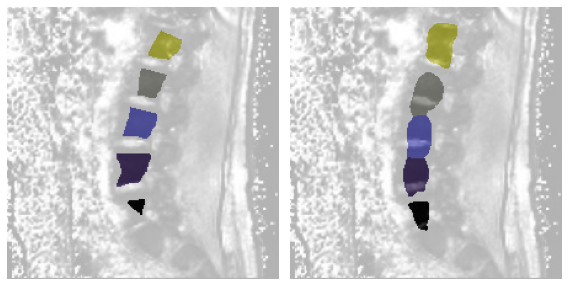

In [11]:
plt.subplot(1,2,1)
plt.yticks([])
plt.xticks([])
plt.imshow(mask_im)
plt.grid(False)
plt.subplot(1,2,2)
plt.yticks([])
plt.xticks([])
plt.imshow(result_pseudo_im)
plt.grid(False)
plt.tight_layout()

plt.savefig(f'mini_fig.pdf', bbox_inches = 'tight')

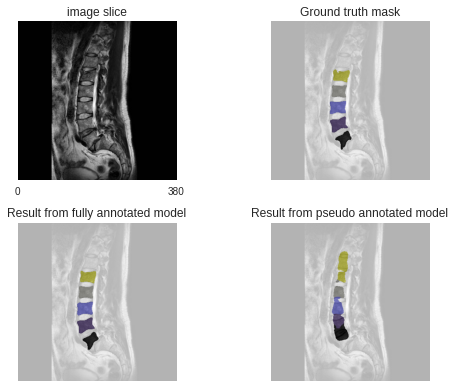

In [12]:
base_path = r'/media/jan/DataStorage/ProjectData/temp/'
result_folder_full = r'reconstruct_full'
result_folder_pseudo = r'reconstruct_pseudo'
dataset = r'dataset_2_contrast_3'
source = r'USiegen'
image_nr = 12
slice_nr = 24


mask_path = os.path.join(base_path, dataset,  f'{source}_masks', f'image{image_nr:03d}', 'mask_array.npy')
result_path_full = os.path.join(base_path, result_folder_full,  'dimension_2_split_test', f'scan_{source}_{image_nr:03d}_res.npy')
result_path_pseudo = os.path.join(base_path, result_folder_pseudo,  'dimension_2_split_test', f'scan_{source}_{image_nr:03d}_res.npy')
image_path = os.path.join(base_path, dataset, f'{source}_images', f'image{image_nr:03d}', f'slice_{slice_nr:03d}.jpg')


im = Image.open(image_path)
mask = np.take(np.load(mask_path), slice_nr, axis=2)
result_full = np.take(np.load(result_path_full), slice_nr, axis=2)
result_pseudo = np.take(np.load(result_path_pseudo), slice_nr, axis=2)

mask_im = Image.fromarray(np.uint8(cm.gist_stern_r(mask*51)*255)).convert('RGB')
mask_im = cv2.addWeighted(np.array(im), 0.3,np.array(mask_im), 0.7, 0)

result_full_im = Image.fromarray(np.uint8(cm.gist_stern_r(result_full*51)*255)).convert('RGB')
result_full_im = cv2.addWeighted(np.array(im), 0.3,np.array(result_full_im), 0.7, 0)

result_pseudo_im = Image.fromarray(np.uint8(cm.gist_stern_r(result_pseudo*51)*255)).convert('RGB')
result_pseudo_im = cv2.addWeighted(np.array(im), 0.3,np.array(result_pseudo_im), 0.7, 0)


plt.subplot(2,2,1)
plt.yticks([])
plt.xticks(np.linspace(0, im.size[0]-1, 2))
plt.title('image slice')
plt.imshow(np.asarray(im))
plt.grid(False)
plt.subplot(2,2,2)
plt.yticks([])
plt.xticks([])
plt.imshow(mask_im)
plt.grid(False)
plt.title('Ground truth mask')
plt.subplot(2,2,3)
plt.yticks([])
plt.xticks([])
plt.imshow(result_full_im)
plt.grid(False)
plt.title('Result from fully annotated model')
plt.subplot(2,2,4)
plt.yticks([])
plt.xticks([])
plt.imshow(result_pseudo_im)
plt.grid(False)
plt.title('Result from pseudo annotated model')
plt.tight_layout()

plt.savefig(f'fullvsPseudo_{source}_{image_nr:03d}_{slice_nr:03d}.pdf', bbox_inches = 'tight')

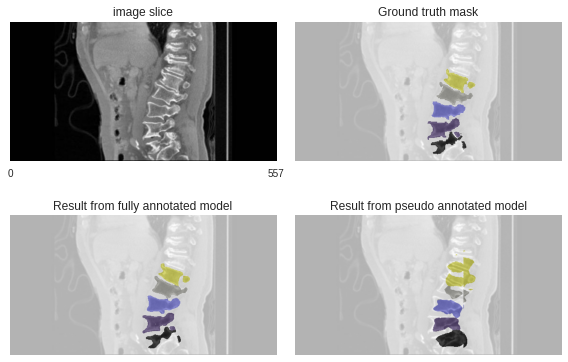

In [13]:
base_path = r'/media/jan/DataStorage/ProjectData/temp/'
result_folder_full = r'reconstruct_full'
result_folder_pseudo = r'reconstruct_pseudo'
dataset = r'dataset_2_contrast_3'
source = r'xVertSeg'
image_nr = 14
slice_nr = 260


mask_path = os.path.join(base_path, dataset,  f'{source}_masks', f'image{image_nr:03d}', 'mask_array.npy')
result_path_full = os.path.join(base_path, result_folder_full,  'dimension_2_split_test', f'scan_{source}_{image_nr:03d}_res.npy')
result_path_pseudo = os.path.join(base_path, result_folder_pseudo,  'dimension_2_split_test', f'scan_{source}_{image_nr:03d}_res.npy')
image_path = os.path.join(base_path, dataset, f'{source}_images', f'image{image_nr:03d}', f'slice_{slice_nr:03d}.jpg')


im = Image.open(image_path)
mask = np.take(np.load(mask_path), slice_nr, axis=2)
result_full = np.take(np.load(result_path_full), slice_nr, axis=2)
result_pseudo = np.take(np.load(result_path_pseudo), slice_nr, axis=2)

mask_im = Image.fromarray(np.uint8(cm.gist_stern_r(mask*51)*255)).convert('RGB')
mask_im = cv2.addWeighted(np.array(im), 0.3,np.array(mask_im), 0.7, 0)

result_full_im = Image.fromarray(np.uint8(cm.gist_stern_r(result_full*51)*255)).convert('RGB')
result_full_im = cv2.addWeighted(np.array(im), 0.3,np.array(result_full_im), 0.7, 0)

result_pseudo_im = Image.fromarray(np.uint8(cm.gist_stern_r(result_pseudo*51)*255)).convert('RGB')
result_pseudo_im = cv2.addWeighted(np.array(im), 0.3,np.array(result_pseudo_im), 0.7, 0)


plt.subplot(2,2,1)
plt.title('image slice')
plt.yticks([])
plt.xticks(np.linspace(0, im.size[0]-1, 2))
plt.imshow(np.asarray(im))
plt.grid(False)
plt.subplot(2,2,2)
plt.yticks([])
plt.xticks([])
plt.imshow(mask_im)
plt.grid(False)
plt.title('Ground truth mask')
plt.subplot(2,2,3)
plt.yticks([])
plt.xticks([])
plt.imshow(result_full_im)
plt.grid(False)
plt.title('Result from fully annotated model')
plt.subplot(2,2,4)
plt.yticks([])
plt.xticks([])
plt.imshow(result_pseudo_im)
plt.grid(False)
plt.title('Result from pseudo annotated model')
plt.tight_layout()

plt.savefig(f'fullvsPseudo_{source}_{image_nr:03d}_{slice_nr:03d}.pdf', bbox_inches = 'tight')

In [14]:
grey = 0.925

def set_ax(ax):
    ax.patch.set_facecolor('white')
    ax.elev = 20
    ax.set_xlabel('left-right [mm]')
    ax.set_ylabel('anteroposterior [mm]')
    ax.set_zlabel('craniocaudal [mm]')
    set_axes_equal(ax)
    ax.w_xaxis.set_pane_color((grey, grey, grey, 1.0))
    ax.w_yaxis.set_pane_color((grey, grey, grey, 1.0))
    ax.w_zaxis.set_pane_color((grey, grey, grey, 1.0))

def plot_vol(ax, vol):
    visiblebox = vol != 0
    _ = ax.voxels(filled = visiblebox, facecolors = cm.gist_stern_r(vol*51), alpha=0.95)
    set_ax(ax)

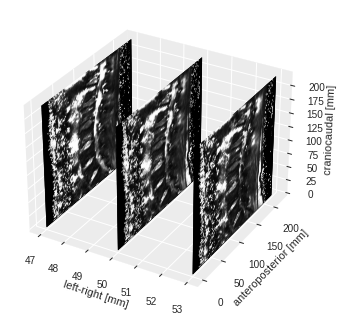

In [15]:
base_path = r'/media/jan/DataStorage/ProjectData/temp/'
dataset = r'dataset_2_contrast_3'
source = r'MyoSegmenTUM'
image_nr = 34
mask_path = os.path.join(base_path, dataset,  f'{source}_masks', f'image{image_nr:03d}', 'mask_array.npy')
volume_path = os.path.join(base_path, dataset,  f'{source}_images', f'image{image_nr:03d}', 'volume.npy')

mask = np.rot90(np.load(mask_path), axes = (2,0))
volume = np.rot90(np.load(volume_path), axes = (2,0))

n_x, n_y, n_z = volume.shape
min_val = volume.min()
max_val = volume.max()

x_cut_50 = volume[50,:,:]
x_cut_53 = volume[53,:,:]
x_cut_47 = volume[47,:,:]
Y, Z = np.mgrid[0:n_y, 0:n_z]
X_50 = 50 * np.ones((n_y, n_z))
X_53 = 53 * np.ones((n_y, n_z))
X_47 = 47 * np.ones((n_y, n_z))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.patch.set_facecolor('white')
ax.set_xlabel('left-right [mm]')
ax.set_ylabel('anteroposterior [mm]')
ax.set_zlabel('craniocaudal [mm]')
ax.w_xaxis.set_pane_color((grey, grey, grey, 1.0))
ax.w_yaxis.set_pane_color((grey, grey, grey, 1.0))
ax.w_zaxis.set_pane_color((grey, grey, grey, 1.0))

ax.plot_surface(X_50, Y, Z, rstride=1, cstride=1, facecolors=cm.Greys_r(x_cut_50), shade=False)
ax.plot_surface(X_53, Y, Z, rstride=1, cstride=1, facecolors=cm.Greys_r(x_cut_53), shade=False)
ax.plot_surface(X_47, Y, Z, rstride=1, cstride=1, facecolors=cm.Greys_r(x_cut_47), shade=False)
plt.savefig(f'Context_slices.pdf', bbox_inches = 'tight')


x-span : [-81.55000000000001, 161.55]
y-span : [-11.050000000000011, 232.05]
z-span : [-11.050000000000011, 232.05]
x-span : [-81.55000000000001, 161.55]
y-span : [-11.050000000000011, 232.05]
z-span : [-11.050000000000011, 232.05]
x-span : [-81.55000000000001, 161.55]
y-span : [-11.050000000000011, 232.05]
z-span : [-11.050000000000011, 232.05]
x-span : [-81.55000000000001, 161.55]
y-span : [-11.050000000000011, 232.05]
z-span : [-11.050000000000011, 232.05]
x-span : [-81.55000000000001, 161.55]
y-span : [-11.050000000000011, 232.05]
z-span : [-11.050000000000011, 232.05]


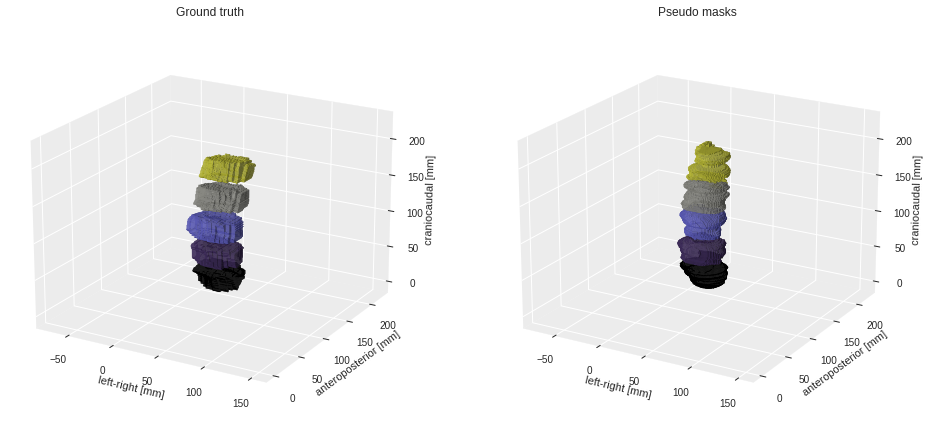

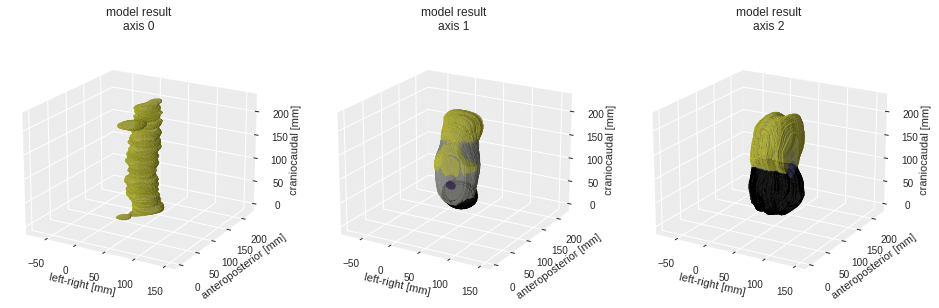

In [16]:
plt.style.use("seaborn-bright")

base_path = r'/media/jan/DataStorage/ProjectData/temp/'
dataset = r'dataset_2_contrast_3'
source = r'MyoSegmenTUM'
image_nr = 34
mask_path = os.path.join(base_path, dataset,  f'{source}_masks', f'image{image_nr:03d}', 'mask_array.npy')

reconstruct_path = r'reconstruct_from_precalc'
split = 'train'

s_dim_path = [
    os.path.join(base_path, 
                 reconstruct_path,  
                 f'dimension_{i}_split_{split}', 
                 f'scan_{source}_{image_nr:03d}_res.npy') for i in range(3)
]

result_comb_path =  os.path.join(base_path, 
                 reconstruct_path,  
                 'volumes', 
                 f'morphcombined_train_{source}_{image_nr:03d}.npy')

mask = np.rot90(np.load(mask_path), axes = (2,0))
s_dim = [np.rot90(np.load(s), axes=(2,0)) for s in s_dim_path]
result_comb = np.rot90(np.load(result_comb_path), axes = (2,0))

plt.figure(figsize = (16,16))
ax = plt.subplot(1,2,1, projection='3d')
plot_vol(ax, mask)
ax.set_title('Ground truth')

ax = plt.subplot(1,2,2, projection='3d')
plot_vol(ax,  result_comb)
ax.set_title('Pseudo masks')
plt.savefig(f'GroundTruth_morphComb_{source}_{image_nr:03d}.png', bbox_inches = 'tight')

plt.figure(figsize = (16, 16))
for i, s in enumerate(s_dim):
    ax = plt.subplot(1,3,i+1, projection='3d')
    plot_vol(ax,s)
    ax.set_title(f'model result\naxis {i}')
plt.savefig(f'SingleDims_{source}_{image_nr:03d}.png', bbox_inches = 'tight')

x-span : [-134.55, 196.55]
y-span : [-15.050000000000011, 316.05]
z-span : [-15.050000000000011, 316.05]
x-span : [-134.55, 196.55]
y-span : [-15.050000000000011, 316.05]
z-span : [-15.050000000000011, 316.05]
x-span : [-134.55, 196.55]
y-span : [-15.050000000000011, 316.05]
z-span : [-15.050000000000011, 316.05]
x-span : [-134.55, 196.55]
y-span : [-15.050000000000011, 316.05]
z-span : [-15.050000000000011, 316.05]
x-span : [-134.55, 196.55]
y-span : [-15.050000000000011, 316.05]
z-span : [-15.050000000000011, 316.05]


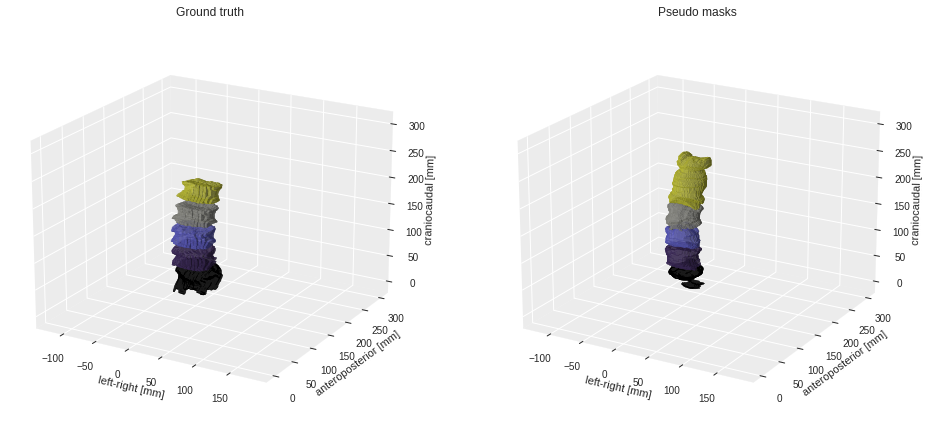

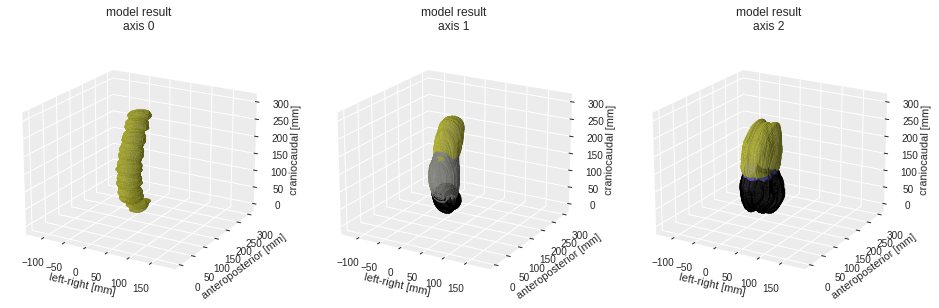

In [17]:
base_path = r'/media/jan/DataStorage/ProjectData/temp/'
dataset = r'dataset_2_contrast_3'
source = r'USiegen'
image_nr = 7
mask_path = os.path.join(base_path, dataset,  f'{source}_masks', f'image{image_nr:03d}', 'mask_array.npy')

reconstruct_path = r'reconstruct_from_precalc'
split = 'train'

s_dim_path = [
    os.path.join(base_path, 
                 reconstruct_path,  
                 f'dimension_{i}_split_{split}', 
                 f'scan_{source}_{image_nr:03d}_res.npy') for i in range(3)
]

result_comb_path =  os.path.join(base_path, 
                 reconstruct_path,  
                 'volumes', 
                 f'morphcombined_train_{source}_{image_nr:03d}.npy')

mask = np.rot90(np.load(mask_path), axes = (2,0))
s_dim = [np.rot90(np.load(s), axes=(2,0)) for s in s_dim_path]
result_comb = np.rot90(np.load(result_comb_path), axes = (2,0))

plt.figure(figsize = (16,16))
ax = plt.subplot(1,2,1, projection='3d')
plot_vol(ax, mask)
ax.set_title('Ground truth')

ax = plt.subplot(1,2,2, projection='3d')
plot_vol(ax, result_comb)
ax.set_title('Pseudo masks')
plt.savefig(f'GroundTruth_morphComb_{source}_{image_nr:03d}.png', bbox_inches = 'tight')

plt.figure(figsize = (16, 16))
for i, s in enumerate(s_dim):
    ax = plt.subplot(1,3,i+1, projection='3d')
    plot_vol(ax, s)
    ax.set_title(f'model result\naxis {i}')
plt.savefig(f'SingleDims_{source}_{image_nr:03d}.png', bbox_inches = 'tight')

x-span : [-18.44999999999999, 387.45]
y-span : [-18.44999999999999, 387.45]
z-span : [-84.94999999999999, 320.95]
x-span : [-18.44999999999999, 387.45]
y-span : [-18.44999999999999, 387.45]
z-span : [-84.94999999999999, 320.95]
x-span : [-18.44999999999999, 387.45]
y-span : [-18.44999999999999, 387.45]
z-span : [-84.94999999999999, 320.95]
x-span : [-18.44999999999999, 387.45]
y-span : [-18.44999999999999, 387.45]
z-span : [-84.94999999999999, 320.95]
x-span : [-18.44999999999999, 387.45]
y-span : [-18.44999999999999, 387.45]
z-span : [-84.94999999999999, 320.95]


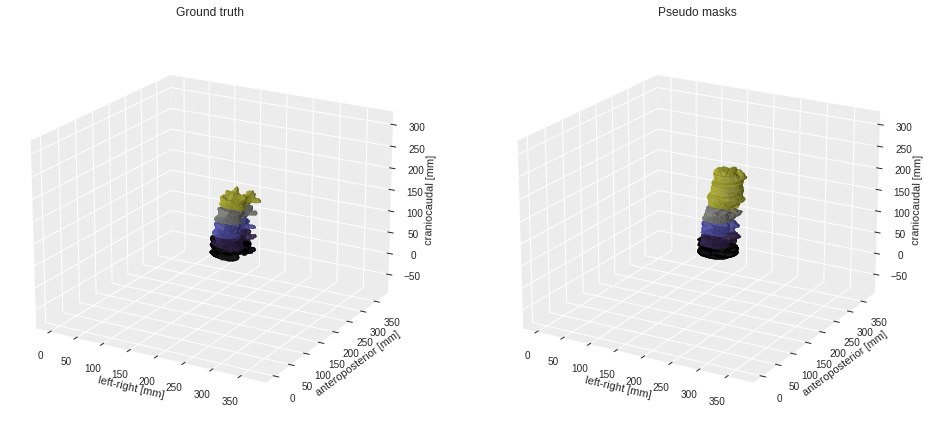

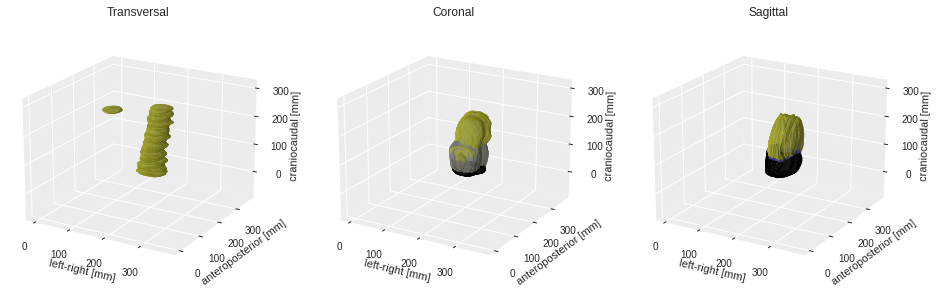

In [18]:
base_path = r'/media/jan/DataStorage/ProjectData/temp/'
dataset = r'dataset_2_contrast_3'
source = r'xVertSeg'
image_nr = 10
mask_path = os.path.join(base_path, dataset,  f'{source}_masks', f'image{image_nr:03d}', 'mask_array.npy')

reconstruct_path = r'reconstruct_from_precalc'
split = 'train'

s_dim_path = [
    os.path.join(base_path, 
                 reconstruct_path,  
                 f'dimension_{i}_split_{split}', 
                 f'scan_{source}_{image_nr:03d}_res.npy') for i in range(3)
]

result_comb_path =  os.path.join(base_path, 
                 reconstruct_path,  
                 'volumes', 
                 f'morphcombined_train_{source}_{image_nr:03d}.npy')

mask = np.rot90(np.load(mask_path), axes = (2,0))
s_dim = [np.rot90(np.load(s), axes=(2,0)) for s in s_dim_path]
result_comb = np.rot90(np.load(result_comb_path), axes = (2,0))

plt.figure(figsize = (16,16))
ax = plt.subplot(1,2,1, projection='3d')
plot_vol(ax, mask)
ax.set_title('Ground truth')

ax = plt.subplot(1,2,2, projection='3d')
plot_vol(ax, result_comb)
ax.set_title('Pseudo masks')
plt.savefig(f'GroundTruth_morphComb_{source}_{image_nr:03d}.png', bbox_inches = 'tight')

plt.figure(figsize = (16, 16))
titles = ['Transversal', 'Coronal', 'Sagittal']
for i, s in enumerate(s_dim):
    ax = plt.subplot(1,3,i+1, projection='3d')
    plot_vol(ax, s)
    ax.set_title(titles[i])
plt.savefig(f'SingleDims_{source}_{image_nr:03d}.png', bbox_inches = 'tight')

x-span : [-184.0, 399.0]
y-span : [-184.0, 399.0]
z-span : [0.0, 583.0]


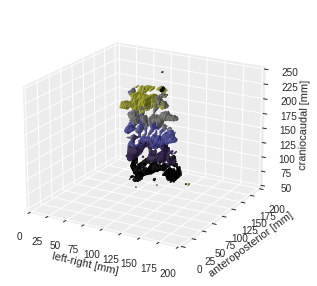

In [19]:
base_path = r'/media/jan/DataStorage/ProjectData/temp/'
dataset = r'UWspine_reconstruct/dimension_2_split_test'
image_nr = 62

reconstruct_path = os.path.join(base_path, dataset, f'scan_UW_{image_nr:03d}_res.npy')

reconstruct = np.rot90(np.load(reconstruct_path), axes = (2,0))


plt.figure(figsize = (5,5))
ax = plt.subplot(1,1,1, projection='3d')
plot_vol(ax, reconstruct)
ax.set_xlim3d([0,200])
ax.set_ylim3d([0,200])
ax.set_zlim3d([50, 250])

plt.savefig(f'UW_result.pdf', bbox_inches = 'tight')

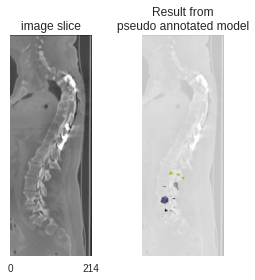

In [20]:
base_path = r'/media/jan/DataStorage/ProjectData/temp/'
dataset = r'UWspine_reconstruct/dimension_2_split_test'
image_nr = 62
slice_nr=103

result_path_pseudo = os.path.join(base_path, dataset, f'scan_UW_{image_nr:03d}_res.npy')
image_path = os.path.join(base_path, 'uWash/UW_images', f'image{image_nr:03d}', f'slice_{slice_nr:03d}.jpg')


im = Image.open(image_path)
result_pseudo = np.take(np.load(result_path_pseudo), slice_nr, axis=2)

result_pseudo_im = Image.fromarray(np.uint8(cm.gist_stern_r(result_pseudo*51)*255)).convert('RGB')
result_pseudo_im = cv2.addWeighted(np.array(im), 0.3,np.array(result_pseudo_im), 0.7, 0)

plt.figure(figsize = (4,4))
plt.subplot(1,2,1)
plt.title('image slice')
plt.yticks([])
plt.xticks(np.linspace(0, im.size[0]-1, 2))
plt.imshow(np.asarray(im))
plt.grid(False)
plt.subplot(1,2,2)
plt.yticks([])
plt.xticks([])
plt.imshow(result_pseudo_im)
plt.grid(False)
plt.title('Result from\npseudo annotated model')
plt.tight_layout()

plt.savefig(f'fullvsPseudo_UW_{image_nr:03d}_{slice_nr:03d}.pdf', bbox_inches = 'tight')

x-span : [-107.0, 308.0]
y-span : [-107.0, 308.0]
z-span : [0.0, 415.0]


Text(0.5, 0.92, 'model result')

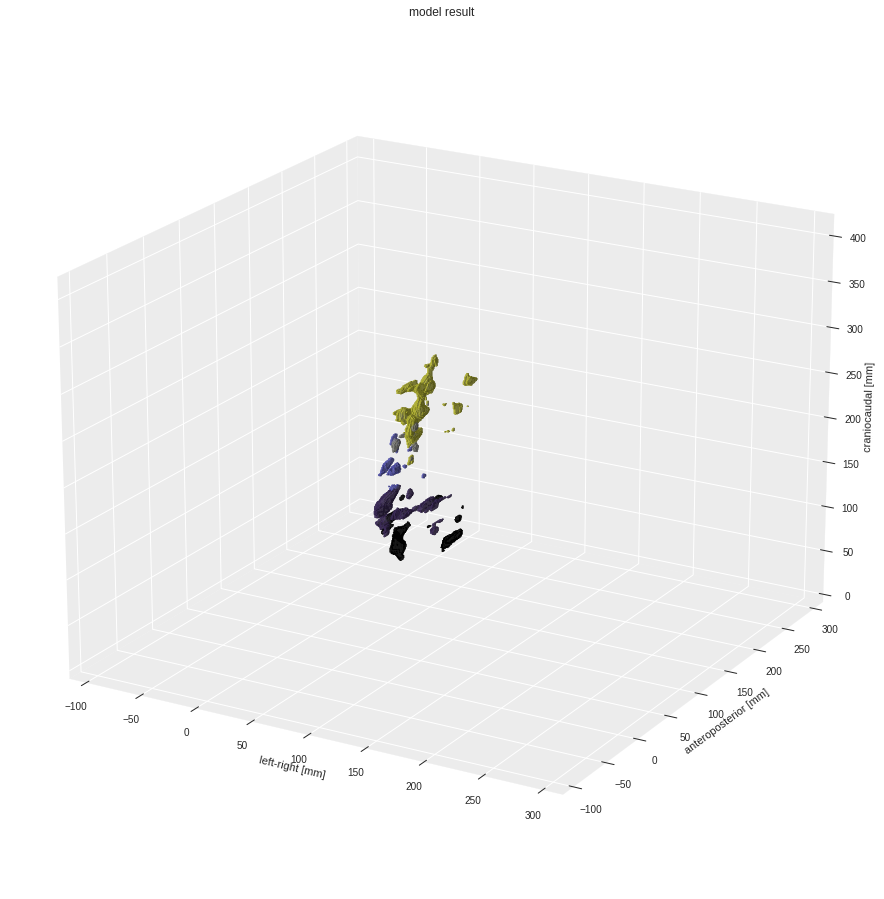

In [21]:
base_path = r'/media/jan/DataStorage/ProjectData/temp/'
dataset = r'UWspine_reconstruct/dimension_2_split_test'
image_nr = 102

reconstruct_path = os.path.join(base_path, dataset, f'scan_UW_{image_nr:03d}_res.npy')

reconstruct = np.rot90(np.load(reconstruct_path), axes = (2,0))


plt.figure(figsize = (16,16))
ax = plt.subplot(1,1,1, projection='3d')
plot_vol(ax, reconstruct)
ax.set_title('model result')

x-span : [-126.5, 306.5]
y-span : [-126.5, 306.5]
z-span : [0.0, 433.0]


Text(0.5, 0.92, 'Ground truth')

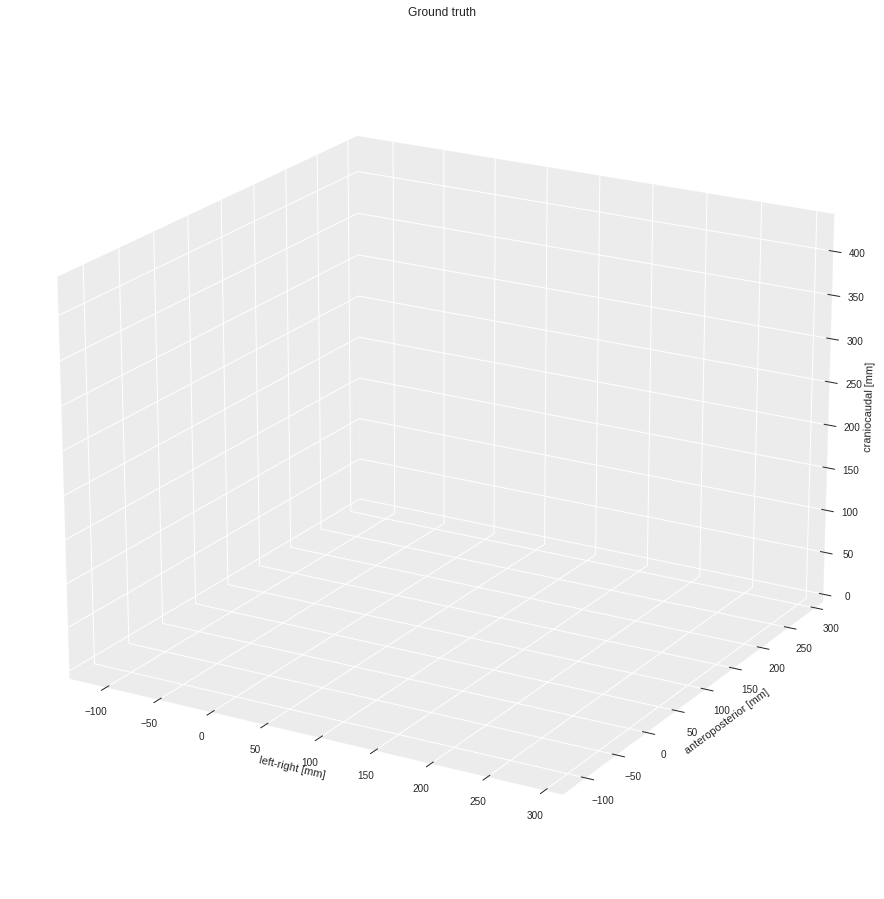

In [22]:
base_path = r'/media/jan/DataStorage/ProjectData/temp/'
dataset = r'UWspine_reconstruct/dimension_2_split_test'
image_nr = 3

reconstruct_path = os.path.join(base_path, dataset, f'scan_UW_{image_nr:03d}_res.npy')

reconstruct = np.rot90(np.load(reconstruct_path), axes = (2,0))


plt.figure(figsize = (16,16))
ax = plt.subplot(1,1,1, projection='3d')
plot_vol(ax, reconstruct)
ax.set_title('Ground truth')

x-span : [-6.599999999999994, 138.6]
y-span : [-6.599999999999994, 138.6]
z-span : [-33.599999999999994, 111.6]


Text(0.5, 0.92, 'model result')

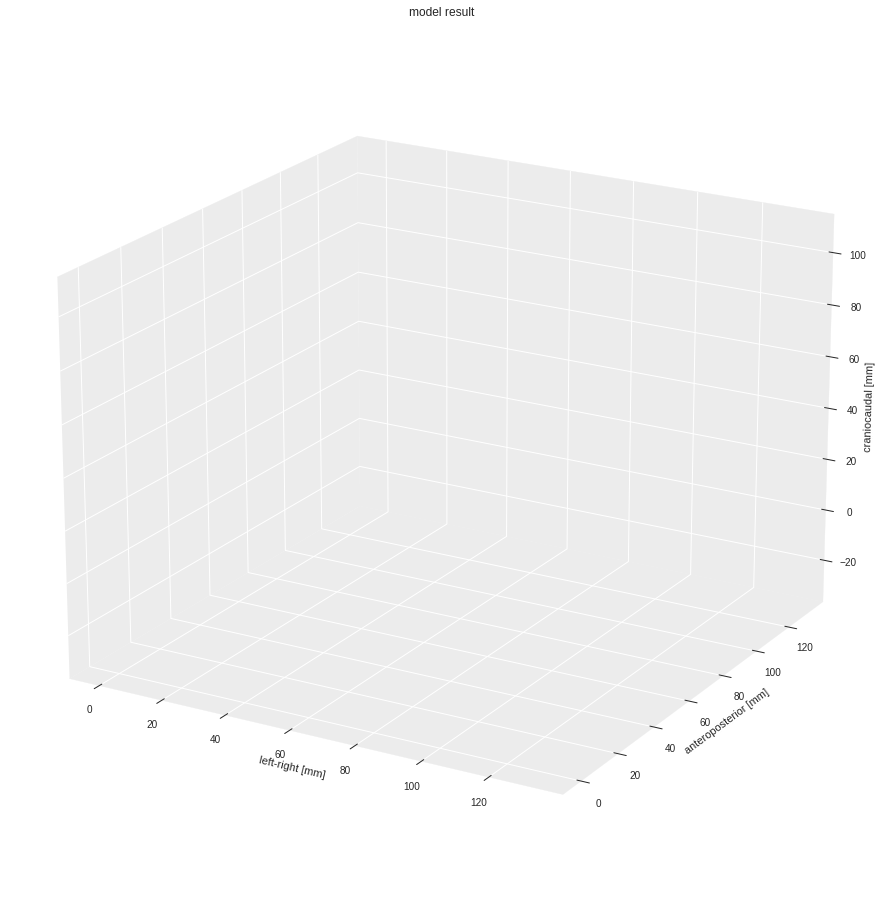

In [23]:
base_path = r'/media/jan/DataStorage/ProjectData/temp/'
dataset = r'UWspine_reconstruct/dimension_2_split_test'
image_nr = 98

reconstruct_path = os.path.join(base_path, dataset, f'scan_UW_{image_nr:03d}_res.npy')

reconstruct = np.rot90(np.load(reconstruct_path), axes = (2,0))


plt.figure(figsize = (16,16))
ax = plt.subplot(1,1,1, projection='3d')
plot_vol(ax, reconstruct)
ax.set_title('model result')

Confusion matrix